In [1]:
from glob import glob
import numpy as np
import rasterio as rio
import os
import pandas as pd
import matplotlib.pyplot as plt

# Importing dataset

In [2]:
root = '.\\steel defect'

In [3]:
images = glob(os.path.join(root, "images", '*.jpg'))

In [4]:
dataset = pd.read_csv('steel defect\\train.csv')


In [5]:
X = []
y = []
for index in range(dataset.shape[0]):
    for i in images:
        image_name = os.path.basename(i)
        if image_name!=dataset['ImageId'].iloc[index]:
            continue
        with rio.open(i, 'r') as f:
            X.append(f.read(1))
            y.append(int(dataset['ClassId'].iloc[index]))
        break  

C:\Users\Mihir\anaconda3\lib\site-packages\rasterio\__init__.py:228: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


# stack data

In [6]:
X = np.stack(X)
y = np.array(y)

# Flatten image array

In [7]:
n_samples = X.shape[0]
X_data = X.reshape((n_samples, -1))

# Data normalization

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_data = sc.fit_transform(X_data)

# Split the dataset into train and test

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data,y, test_size = 0.2, random_state = 1)

3.0    2258
1.0     393
4.0     341
2.0     107
Name: ClassId, dtype: int64

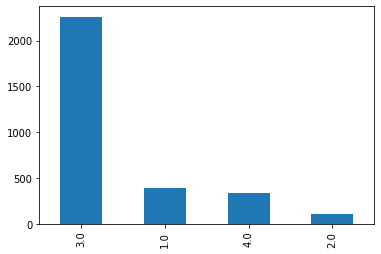

In [11]:
dataset.shape
dataset["ClassId"].value_counts().plot(kind = 'bar')
dataset["ClassId"].value_counts()

# Clssified Image Search

image of defect class 3


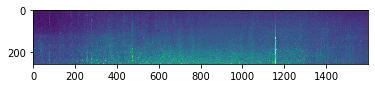

In [12]:
for i in range (len(y)):
    j=3
    if y[i]==j:
        plt.imshow(X[i])
        print("image of defect class",j)
        break

# <span style="color:red;">CNN classifier</span>

In [10]:
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tqdm import tqdm
import cv2
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout

Using TensorFlow backend.


In [16]:
# Image argumantation
l1=[]
l2=[] 
for ImageId,ClassId,EncodedPixels in tqdm(dataset.values):
    image=cv2.imread("steel defect\\images/{}".format(ImageId),cv2.IMREAD_COLOR)
    if image is not None:
        image=cv2.resize(image,dsize=(256,256))
        l1.append(image)
        l2.append(ClassId)

    

100%|█████████████████████████████████████████████████████████████████████████████| 6014/6014 [00:28<00:00, 211.69it/s]


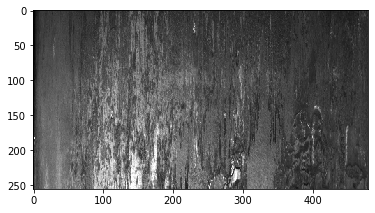

In [13]:
i = 15
plt.imshow(l1[i])

In [16]:
print(len(l1))

3099


In [14]:
encoder = LabelEncoder()
X= np.array(l1)
X = X/255
y = encoder.fit_transform(l2)
y = to_categorical(y)

In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

MemoryError: Unable to allocate 1.70 GiB for an array with shape (620, 256, 480, 3) and data type float64

In [ ]:
print("x_train shape:",X_train.shape)
print("x_test shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

In [ ]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(256,256,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))
model.summary()

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,min_delta=0.001,restore_best_weights=True)

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.Adam(),metrics=["accuracy"])

In [ ]:
history = model.fit(X_train,y_train,epochs=15,validation_data=(X_test,y_test),batch_size=128,verbose=1, callbacks=[early_stopping])

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

In [ ]:
result = model.evaluate(X_test, y_test)

loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

# <span style="color:red;">Xception</span>

In [ ]:
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, BatchNormalization, Dropout

In [ ]:
# Image argumantation
l1=[]
l2=[] 
for ImageId,ClassId,EncodedPixels in tqdm(dataset.values):
    image=cv2.imread("steel defect\\images/{}".format(ImageId),cv2.IMREAD_COLOR)
    if image is not None:
        image=cv2.resize(image,dsize=(256,256))
        l1.append(image)
        l2.append(ClassId)

In [ ]:
encoder = LabelEncoder()
X= np.array(l1)
X = X/255
y = encoder.fit_transform(l2)
y = to_categorical(y)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

In [3]:
Classification_Model = keras.applications.xception.Xception(include_top = False, input_shape = (256,256,3))

layer = Classification_Model.output
layer = GlobalAveragePooling2D()(layer)

layer = Dense(1024, activation='relu')(layer)
layer = BatchNormalization()(layer)
layer = Dropout(0.3)(layer)

layer = Dense(512, activation='relu')(layer)
layer = BatchNormalization()(layer)
layer = Dropout(0.3)(layer)

layer = Dense(64, activation='relu')(layer)
predictions = Dense(4, activation='softmax')(layer)
model = Model(inputs=Classification_Model.input, outputs=predictions)
model.summary()

NameError: name 'keras' is not defined

In [2]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(X_train,y_train,epochs=30,validation_data=(X_test,y_test),batch_size=128,verbose=1)

NameError: name 'model' is not defined

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

In [ ]:
result = model.evaluate(X_test, y_test)

loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")